In [117]:
import anndata as ad
import pandas as pd
import re
import numpy as np
from statsmodels.formula.api import glm
from statsmodels.genmod.families import Poisson, NegativeBinomial
from statsmodels.stats.multitest import fdrcorrection
from sklearn.utils import resample
from typing import List

# Definition of Functions

In [118]:
# Defines the Python class used for structuring data input required by the algorithms.
class Single_Cell_Data:
    def __init__(self, rna: ad.AnnData, atac: ad.AnnData, meta_data: pd.DataFrame,
                 peak_info: pd.DataFrame,
                 covariates: List[str], celltypes: str, peak_info_list: List[pd.DataFrame] = None):
        """
        Initialize SCENT object with required data and parameters.
        
        Parameters:
        - rna: ad.AnnData. AnnData object representing scRNAseq data.
        - atac: ad.AnnData. AnnData object representing scATACseq data.
        - meta_data: pd.DataFrame. Metadata with covariates and cell ID column.
        - peak_info: pd.DataFrame. Gene-peak pairs for SCENT analysis.
        - covariates: List[str]. Covariates needed for the analysis, must be in meta_data columns.
        - celltypes: str. Column name in meta_data that defines cell types.
        - peak_info_list: List[pd.DataFrame]. List of gene-peak pairs for parallel processing. (We don't need it.)
        """
        self.rna = rna
        self.atac = atac
        self.meta_data = meta_data
        self.peak_info = peak_info
        # self.peak_info_list = peak_info_list
        self.covariates = covariates
        self.celltypes = celltypes
        self.SCENT_result = pd.DataFrame()  # Empty DataFrame for results
        self.linear_result = pd.DataFrame()

        # Check dimensions
        self.check_dimensions()

    def check_dimensions(self):
        """
        Validity and Type Checking for SCENT object constructor.
        Ensures RNA and ATAC matrices have consistent dimensions with metadata.
        """
        errors = []

        # Check that rna and atac have matching cell IDs
        if not (self.rna.obs_names.equals(self.atac.obs_names)):
            errors.append("The cells (obs_names) in rna and atac do not match.")

        # Check that celltypes column exists in meta_data
        if self.celltypes not in self.meta_data.columns:
            errors.append(f"Cell type column '{self.celltypes}' not found in metadata.")

        # Check that covariates are present in meta_data
        missing_covariates = [cov for cov in self.covariates if cov not in self.meta_data.columns]
        if missing_covariates:
            errors.append(f"Missing covariate(s) in metadata: {', '.join(missing_covariates)}")

        # Warning if peak count is unexpectedly low compared to gene count
        if self.atac.shape[1] < self.rna.shape[1]:
            print("Warning: Typically, there are more peaks than genes. "
                  f"Currently, you have {self.atac.shape[1]} peaks and {self.rna.shape[1]} genes.")

        # Check if peak_info has genes and peaks that match rna and atac
        if not all(self.peak_info['gene'].isin(self.rna.var_names)):
            errors.append("Some gene names in peak_info are not present in the RNA data.")

        if not all(self.peak_info['peak'].isin(self.atac.var_names)):
            errors.append("Some peak names in peak_info are not present in the ATAC data.")

        if errors:
            raise ValueError("Single Cell Data object validation failed with the following errors:\n" + "\n".join(errors))

In [119]:
# SCENT algorithm
def basic_p(obs, boot, null=0):
    # Interpolated p-value function in Python
    boot_centered = 2 * obs - boot - null
    R = len(boot_centered)
    zero = np.sum(boot_centered >= 0)
    if zero == 0 or zero == R:
        return 2 / R
    pval = 2 * min(zero / R, (R - zero) / R)
    return pval

def assoc_poisson(data, formula):
    # Fit Poisson regression and return coefficient and variance for 'atac'
    model = glm(formula=formula, data=data, family=Poisson()).fit()
    coef = model.params['atac']
    var = model.cov_params().loc['atac', 'atac']
    return coef, var

def assoc_negbin(data, formula):
    # Fit Negative Binomial regression and return coefficient and variance for 'atac'
    model = glm(formula=formula, data=data, family=NegativeBinomial()).fit()
    coef = model.params['atac']
    var = model.cov_params().loc['atac', 'atac']
    return coef, var

def adaptive_bootstrap(df, assoc_func, formula):
    # Initial bootstrapping round and adaptive p-value calculation
    # bootstrap_rounds = [100, 500, 2500, 25000, 50000]
    # p_thresholds = [0.1, 0.05, 0.01, 0.001]
    bootstrap_rounds = [100, 500, 2500]
    p_thresholds = [0.1, 0.05]
    p_value = None
    
    for i, R in enumerate(bootstrap_rounds):
        # Run bootstrap sequentially
        boot_coefs = []
        for _ in range(R):
            coef, _ = bootstrap_sample(df, assoc_func, formula)
            boot_coefs.append(coef)

        # print('done one bootstrap')
        
        # Convert to array for easier calculations
        boot_coefs = np.array(boot_coefs)

        # Calculate p-value
        observed_coef, _ = assoc_func(df, formula)
        p_value = basic_p(observed_coef, boot_coefs)
        
        if i < len(p_thresholds) and p_value >= p_thresholds[i]:
            break  # Stop if p-value is above threshold

    return p_value

def bootstrap_sample(df, assoc_func, formula):
    # Helper function to perform bootstrap resampling and estimate coefficient
    df_sample = resample(df, replace=True)  # Resample with replacement
    return assoc_func(df_sample, formula)

def SCENT_algorithm(object, celltype=None, regr="poisson", binarize=True):
    results = []
    for n in range(object.peak_info.shape[0]):
        gene = object.peak_info.loc[n, 'gene']  # First column is gene
        gene_id = object.peak_info.loc[n, 'gene_id']
        this_peak = object.peak_info.loc[n, 'peak']  # Second column is peak

        # Extract data for atac_target and mrna_target
        atac_target = pd.DataFrame({'cell': object.atac.obs_names, 'atac': object.atac[:, this_peak].X.toarray().flatten()})
        
        # Binarize peak accessibility if required
        if binarize:
            atac_target['atac'] = (atac_target['atac'] > 0).astype(int)

        mrna_target = pd.DataFrame({'cell': object.rna.obs_names, 'exprs': object.rna[:, gene].X.toarray().flatten()})
        df = pd.merge(mrna_target, atac_target, on='cell')
        df = pd.merge(df, object.meta_data, on='cell')
        
        if celltype is not None:
            df_filtered = df[df[object.celltypes] == celltype]
        else:
            df_filtered = df
        
        # Check for non-zero threshold
        nonzero_m = np.sum(df_filtered['exprs'] > 0) / len(df_filtered['exprs'])
        nonzero_a = np.sum(df_filtered['atac'] > 0) / len(df_filtered['atac'])

        # print(nonzero_m, nonzero_a)
        
        if nonzero_m > 0.05 and nonzero_a > 0.05:
            res_var = 'exprs'
            pred_vars = ['atac'] + object.covariates
            formula = f"{res_var} ~ {' + '.join(pred_vars)}"
            
            # Fit model based on regression type
            if regr == "poisson":
                coef, var = assoc_poisson(df_filtered, formula)
                assoc_func = assoc_poisson
            elif regr == "negbin":
                coef, var = assoc_negbin(df_filtered, formula)
                assoc_func = assoc_negbin
            
            # Adaptive bootstrapping without multiprocessing
            p0 = adaptive_bootstrap(df_filtered, assoc_func, formula)
            
            # Collect results
            result = {'gene': gene, 'gene_id': gene_id, 'peak': this_peak, 'beta': coef, 'variance': var, 'p_value': p0}
            results.append(result)
    
    object.SCENT_result = pd.DataFrame(results)
    return object

In [120]:
# Evaluation Tools
def apply_fdr(df, fdr_threshold=0.05):
    """
    Applies FDR correction to p-values for each gene in the DataFrame.
    
    Parameters:
    - df: DataFrame with columns 'gene_id', 'peak', and 'p_value'
    - fdr_threshold: Desired FDR level for significance testing (default: 0.05)
    
    Returns:
    - DataFrame with an additional 'significance' column indicating FDR-adjusted significance.
    """
    results = []

    # Group by 'gene_id' and apply FDR correction to 'p_value' for each group
    for gene, group in df.groupby('gene_id'):
        # Perform FDR correction with the specified threshold
        rejected, _ = fdrcorrection(group['p_value'], alpha=fdr_threshold)
        
        # Add 'significance' column to indicate significant results
        group = group.copy()
        group['significance'] = rejected
        
        results.append(group)
    
    # Concatenate all groups back into a single DataFrame
    result_df = pd.concat(results, ignore_index=True)
    return result_df

def calculate_enrichment(sc_data, eqtl_data, causal_snp_threshold=0.2, cis_region_size = 500_000):
    """
    Calculate the enrichment score for each gene based on causal and common variants.

    Parameters:
    - sc_data: DataFrame, the Single Cell result data for single-cell analysis (typically single_cell_data_obj.SCENT_result).
    - eqtl_data: DataFrame, eQTL fine-mapping data with columns 'gene_id', 'position', and 'probability'.
    - causal_snp_threshold: float, threshold for causal SNP posterior probability.

    Returns:
    - enrichment_df: DataFrame, enrichment values for each gene.
    - overall_enrichment: float, mean enrichment across all genes.
    """
    # Separate causal and common variants from eQTL data based on probability threshold
    causal_eqtl_data = eqtl_data[eqtl_data['probability'] >= causal_snp_threshold]
    common_eqtl_data = eqtl_data  # All variants in eqtl_data are considered common

    # Dictionary to store enrichment values for each gene
    enrichment_results = []
    
    # Iterate over each unique gene in the eQTL data
    for gene in sc_data['gene_id'].unique():
        # Filter single-cell data to get significant peaks for this gene
        gene_peaks = sc_data[
            (sc_data['gene_id'] == gene) &
            (sc_data['significance'] == True)
        ]
        
        # Filter causal and common variants for the current gene
        gene_causal_variants = causal_eqtl_data[causal_eqtl_data['gene_id'] == gene]
        gene_common_variants = common_eqtl_data[common_eqtl_data['gene_id'] == gene]
        
        # Initialize counters for causal and common variants within annotation
        causal_var_in_annot = 0
        common_var_in_annot = 0
        
        # Iterate through each peak in the gene's significant peaks
        for _, peak_row in gene_peaks.iterrows():
            peak_start, peak_end = peak_row['start'], peak_row['end']
            
            # Count causal variants within the peak region
            causal_in_peak = gene_causal_variants[
                (gene_causal_variants['position'] >= peak_start) &
                (gene_causal_variants['position'] <= peak_end)
            ]
            causal_var_in_annot += causal_in_peak.shape[0]
            
            # Count common variants within the peak region
            common_in_peak = gene_common_variants[
                (gene_common_variants['position'] >= peak_start) &
                (gene_common_variants['position'] <= peak_end)
            ]
            common_var_in_annot += common_in_peak.shape[0]
        
        # Total causal and common variants in cis-region (500kb window)
        gene_tss = sc_data[sc_data['gene_id'] == gene]['TSS'][0]
        cis_start, cis_end = gene_tss - cis_region_size, gene_tss + cis_region_size
        causal_var_in_cis = gene_causal_variants[
            (gene_causal_variants['position'] >= cis_start) &
            (gene_causal_variants['position'] <= cis_end)
        ].shape[0]
        
        common_var_in_cis = gene_common_variants[
            (gene_common_variants['position'] >= cis_start) &
            (gene_common_variants['position'] <= cis_end)
        ].shape[0]
        
        # Calculate enrichment for the gene based on the provided formula
        if common_var_in_annot > 0 and common_var_in_cis > 0:  # Avoid division by zero
            enrichment = (causal_var_in_annot / common_var_in_annot) / (causal_var_in_cis / common_var_in_cis)
        else:
            enrichment = None  # Handle cases where there's no valid data for calculation
        
        enrichment_results.append({
            'gene_id': gene,
            'enrichment': enrichment
        })
    
    # Convert results to DataFrame
    enrichment_df = pd.DataFrame(enrichment_results)
    
    # Calculate overall enrichment as the mean of per-gene enrichment values
    overall_enrichment = enrichment_df['enrichment'].mean()
    
    return enrichment_df, overall_enrichment

# Load the Data

In [121]:
# Load the single cell multiome data
adata = ad.read_h5ad('data/single-cell-multiome.h5ad')

In [122]:
# Load the data for extra information about genes

# Define column names based on GTF specifications
column_names = ["seqname", "source", "feature", "start", "end", "score", "strand", "frame", "attribute"]

dtype_dict = {
    "seqname": str,
    "source": str,
    "feature": str,
    "start": int,
    "end": int,
    "score": str,
    "strand": str,
    "frame": str,
    "attribute": str
}

# Load the GTF file (skip comment lines starting with '#')
gtf_file = "data/Homo_sapiens.GRCh38.113.gtf"  # Gene Location
gene_id_info = pd.read_csv(gtf_file, sep="\t", comment='#', names=column_names, header=None, dtype=dtype_dict)

# Function to parse attributes and extract gene_id, gene_version, and gene_name
def parse_attributes(attributes):
    # Define regular expressions to capture each attribute
    gene_id_match = re.search(r'gene_id "([^"]+)"', attributes)
    gene_version_match = re.search(r'gene_version "([^"]+)"', attributes)
    gene_name_match = re.search(r'gene_name "([^"]+)"', attributes)
    transcript_id_match = re.search(r'transcript_id "([^"]+)"', attributes)
    
    # Extract the values if they exist
    gene_id = gene_id_match.group(1) if gene_id_match else None
    gene_version = gene_version_match.group(1) if gene_version_match else None
    gene_name = gene_name_match.group(1) if gene_name_match else None
    transcript_id = transcript_id_match.group(1) if transcript_id_match else None
    
    return pd.Series([gene_id, gene_version, gene_name])

# Apply the function to extract attributes and add as new columns
gene_id_info[['gene_id', 'gene_version', 'gene_name']] = gene_id_info['attribute'].apply(parse_attributes)

In [ ]:
# Load the eQTL finemapping data set
eQTL_finemapping = pd.read_csv('./data/GTEx_v8_finemapping_CAVIAR/CAVIAR_Results_v8_GTEx_LD_ALL_NOCUTOFF.txt', sep='\t')
eQTL_finemapping = eQTL_finemapping.rename(columns={
    'TISSUE': 'tissue',
    'GENE': 'gene_id',
    'CHROM': 'seqname',
    'POS': 'position',
    'Probability': 'probability'
})
eQTL_finemapping['gene_id'] = eQTL_finemapping['gene_id'].str.replace(r'\.\d+$', '', regex=True)
eQTL_finemapping['seqname'] = eQTL_finemapping['seqname'].apply(lambda x: f'chr{x}' if str(x).isdigit() else x)
eQTL_finemapping = eQTL_finemapping.groupby(['seqname', 'gene_id', 'position'], as_index=False)['probability'].max()
eQTL_finemapping.sort_values(by=['seqname', 'gene_id'], inplace=True)

# Preprocess Single Cell Data

In [ ]:
# Aggregate the data for GEX variables. Specifically, match each gene with its location on the genome and the location of TSS

gene_id_loc = gene_id_info[gene_id_info['feature'] == 'gene']
gene_id_loc = gene_id_loc[['seqname', 'start', 'end', 'gene_id', 'strand']]

# Reset the index of adata.var temporarily, if 'gene_id' is in the index
gex_var_reset = adata.var[adata.var['feature_types'] == 'GEX'].copy()
gex_var_reset = gex_var_reset.reset_index()

# Perform the merge
gex_var = pd.merge(
    gex_var_reset, gene_id_loc, on="gene_id", how="left"
)

# Set the index back to the original index of adata.var
gex_var.set_index(gex_var_reset['index'], inplace=True)
gex_var = gex_var.drop('index', axis=1)
gex_var.index.name = None

gex_var['seqname'] = gex_var['seqname'].astype(str)
gex_var['seqname'] = gex_var['seqname'].apply(lambda x: f'chr{x}' if x.isdigit() else x)
# Convert columns to nullable integer type that supports NaN
gex_var['start'] = gex_var['start'].astype('Int64')
gex_var['end'] = gex_var['end'].astype('Int64')

# Calculate TSS based on strand orientation
gex_var['TSS'] = gex_var.apply(lambda row: row['start'] if row['strand'] == '+' else row['end'], axis=1)

In [ ]:
# Aggregate the data for GEX variables. Specifically, match each gene with its location on the genome and the location of TSS

atac_var = adata.var[adata.var['feature_types'] == 'ATAC'].copy()

# Convert index to a DataFrame column temporarily
atac_var['index'] = atac_var.index

# Split the 'index' column into three parts: seqname, start, end
atac_var[['seqname', 'start', 'end']] = atac_var['index'].str.extract(r'([^:]+?)-(\d+)-(\d+)')

# Convert start and end to integers
atac_var['start'] = atac_var['start'].astype(int)
atac_var['end'] = atac_var['end'].astype(int)

# Drop the temporary 'index' column
atac_var = atac_var.drop(columns='index')

In [ ]:
# Filter the data and prepare data for Single_Cell_Data class.

# Filter the cell data
cell_filter = adata.obs['batch'].str.contains('s1d1')

# Filter the GEX data
# Filter the GEX data: Focus on Chromosome 1 and the genes that have frequency at least 0.05
gex_ann_data = adata[cell_filter, adata.var['feature_types'] == 'GEX']
freq_gex = (gex_ann_data.X > 0).mean(axis=0) > 0.05
gex_filter = (gex_var['seqname'] == 'chr1') & (np.array(freq_gex).flatten())
# Filter the GEX data: Randomly Sample {select_size} number of genes
# select_size = 20
# true_indices = np.flatnonzero(gex_filter)
# if len(true_indices) < select_size:
#     selected_indices = true_indices
# selected_indices = np.random.choice(true_indices, size=select_size, replace=False)
# gex_filter = np.zeros_like(gex_filter, dtype=bool)
# gex_filter[selected_indices] = True
gex_filter = (gex_var['gene_id'] == 'ENSG00000228794')
# Filter the GEX data: Prepare the dataset
rna_data = adata[:, adata.var['feature_types'] == 'GEX']
rna_data = rna_data[cell_filter, gex_filter]

# Filter the ATAC data
# Filter the ATAC data: Focus on Chromosome 1 and the peaks that have frequency at least 0.05
atac_ann_data = adata[cell_filter, adata.var['feature_types'] == 'ATAC']
freq_atac = (atac_ann_data.X > 0).mean(axis=0) > 0.05
atac_filter = (atac_var['seqname'] == 'chr1') & (np.array(freq_atac).flatten())
# Filter the ATAC data: Prepare the dataset
atac_data = adata[:, adata.var['feature_types'] == 'ATAC']
atac_data = atac_data[cell_filter, atac_filter]

In [ ]:
# Tidy the meta data for cells

# Define the covariates the add to Poisson regression
covariates = ['GEX_pct_counts_mt', 'GEX_n_counts', 'batch']

# Tidy the cell type categories
t_cells_nk_cells = ['CD4+ T activated', 'CD4+ T naive', 'CD8+ T', 'CD8+ T naive', 'NK', 'ILC']
b_cells = ['B1 B', 'Naive CD20+ B', 'Transitional B', 'Plasma cell']
myeloid_cells = ['CD14+ Mono', 'CD16+ Mono', 'cDC2', 'pDC', 'ID2-hi myeloid prog', 'G/M prog']
def classify_cell_type(cell_type):
    if cell_type in t_cells_nk_cells:
        return "T cells/NK cells"
    elif cell_type in b_cells:
        return "B cells"
    elif cell_type in myeloid_cells:
        return "Myeloid cells"
    else:
        return "other"
adata.obs['cell_category'] = adata.obs['cell_type'].copy()
adata.obs['cell_category'] = adata.obs['cell_type'].apply(classify_cell_type)
celltypes = 'cell_category'

meta_data = adata.obs[cell_filter].copy()
meta_data['cell'] = meta_data.index

In [ ]:
# Matching Genes with Potential Peaks Within Their Cis Region

# Example cis-region size (adjust as needed)
cis_region_size = 500_000

# Initialize an empty list to collect gene-peak pairs
peak_info_list = []
gex_var_filtered = gex_var[gex_filter]
atac_var_filtered = atac_var[atac_filter]

# Loop over each gene in gex_var
for gene, gene_data in gex_var_filtered.iterrows():
    gene_tss = gene_data['TSS']
    gene_chromosome = gene_data['seqname']  # Assuming chromosome information is in 'seqname'

    # Define the cis-region around the TSS
    cis_start = gene_tss - cis_region_size
    cis_end = gene_tss + cis_region_size

    # Filter peaks within this cis-region and on the same chromosome
    cis_peaks = atac_var_filtered[
        (atac_var_filtered['seqname'] == gene_chromosome) &
        (atac_var_filtered['start'] <= cis_end) &
        (atac_var_filtered['end'] >= cis_start)
    ]
    
    # Add each gene-peak pair to the list
    for peak in cis_peaks.index:
        peak_info_list.append({'gene': gene, 'gene_id': gene_data['gene_id'], 'peak': peak})

# Convert the list to a DataFrame
peak_info = pd.DataFrame(peak_info_list)

In [ ]:
# Instantiate Single_Cell_Data object
single_cell_data_obj = Single_Cell_Data(rna=rna_data, atac=atac_data, meta_data=meta_data,
                  peak_info=peak_info, covariates=covariates, celltypes=celltypes)

# Run the Algorithms

In [ ]:
# # Run the SCENT algorithm (you don't need to run this cell)
# single_cell_data_obj = SCENT_algorithm(single_cell_data_obj)
# single_cell_data_obj.SCENT_result = single_cell_data_obj.SCENT_result.merge(atac_var[['seqname', 'start', 'end']], how='left', left_on='peak', right_index=True)
# single_cell_data_obj.SCENT_result = single_cell_data_obj.SCENT_result.merge(gex_var[['gene_id', 'TSS']], how='left', on='gene_id')
# single_cell_data_obj.SCENT_result = apply_fdr(single_cell_data_obj.SCENT_result, fdr_threshold=0.05)

# Evaluate the Results

In [ ]:
# enrichment_df, overall_enrichment = calculate_enrichment(sc_data=single_cell_data_obj.SCENT_result, eqtl_data=eQTL_finemapping)

# Linear Algorithm

In [ ]:
def linear_algorithm(object, binarize=True):
    results = []
    for n in range(object.peak_info.shape[0]):
        # if n == 0:
        #     continue
        # if n != 1:
        #     break
        gene = object.peak_info.loc[n, 'gene']  # First column is gene
        gene_id = object.peak_info.loc[n, 'gene_id']
        this_peak = object.peak_info.loc[n, 'peak']  # Second column is peak
        print(this_peak)

        # Extract data for atac_target and mrna_target
        atac_target = pd.DataFrame({'cell': object.atac.obs_names, 'atac': object.atac[:, this_peak].X.toarray().flatten()})
        
        # Binarize peak accessibility if required
        if binarize:
            atac_target['atac'] = (atac_target['atac'] > 0).astype(int)

        mrna_target = pd.DataFrame({'cell': object.rna.obs_names, 'exprs': object.rna[:, gene].X.toarray().flatten()})
        df = pd.merge(mrna_target, atac_target, on='cell')
        df = pd.merge(df, object.meta_data, on='cell')
        
        # Check for non-zero threshold
        nonzero_m = np.sum(df['exprs'] > 0) / len(df['exprs'])
        nonzero_a = np.sum(df['atac'] > 0) / len(df['atac'])
        
        if nonzero_m > 0.05 and nonzero_a > 0.05:
            # mean center by each cell type
            df['exprs_centered'] = df['exprs'] - df.groupby('cell_type', observed=True)['exprs'].transform('mean')
            df['atac_centered'] = df['atac'] - df.groupby('cell_type', observed=True)['atac'].transform('mean')

            y_prime_list = []
            x_prime_list = []

            # transform data for each cell type
            for _, group in df.groupby('cell_type', observed=True):
                y_cg = group['exprs_centered'].values.reshape(-1, 1)
                
                # Perform SVD
                U, S, VT = np.linalg.svd(y_cg, full_matrices=False)
                
                # Update linear relationship
                y = group['exprs_centered'].values.reshape(-1, 1)
                x = group['atac_centered'].values.reshape(-1, 1)

                try:
                    # Calculate y_prime and x_prime
                    S_inv = np.linalg.inv(np.diag(S))
                    y_prime = np.dot(np.dot(S_inv, U.T), y).flatten()
                    x_prime = np.dot(np.dot(S_inv, U.T), x).flatten()
                    
                    # Append the results for this group
                    y_prime_list.append(y_prime)
                    x_prime_list.append(x_prime)
                except np.linalg.LinAlgError: 
                    # Calculate y_prime and x_prime
                    S_inv = np.diag(S)
                    y_prime = np.dot(np.dot(S_inv, U.T), y).flatten()
                    x_prime = np.dot(np.dot(S_inv, U.T), x).flatten()
                    
                    # Append the results for this group
                    y_prime_list.append(y_prime)
                    x_prime_list.append(x_prime)

            import statsmodels.api as sm
            model = sm.OLS(y_prime_list, x_prime_list)
            model_results = model.fit()

            coef = model_results.params
            var = model_results.bse ** 2
            pvalue = model_results.pvalues
            
            # Collect results
            result = {'gene': gene, 'gene_id': gene_id, 'peak': this_peak, 'beta': coef, 'variance': var, 'p_value': pvalue}
            results.append(result)
    
    object.linear_result = pd.DataFrame(results)
    return object

In [ ]:
single_cell_data_obj = linear_algorithm(single_cell_data_obj)
single_cell_data_obj.linear_result

chr1-629497-630394
chr1-633515-634474
chr1-778276-779191
chr1-827067-827948
chr1-869472-870377
chr1-904343-905196
chr1-958865-959755
chr1-960362-961092
chr1-966515-967329
chr1-1000553-1001085
chr1-1013003-1013921
chr1-1019151-1019993
chr1-1032734-1033630
chr1-1040409-1041296
chr1-1059182-1060025
chr1-1063688-1064577
chr1-1068898-1069703
chr1-1115800-1116696
chr1-1121837-1122746
chr1-1201060-1201925
chr1-1231675-1232596
chr1-1273488-1274400
chr1-1305205-1306136
chr1-1307807-1308738
chr1-1324303-1325203


,gene,gene_id,peak,beta,variance,p_value
0,LINC01128,ENSG00000228794,chr1-629497-630394,[1.1339562555339995],[0.7156203360636536],[0.19512404209318662]
1,LINC01128,ENSG00000228794,chr1-633515-634474,[-0.44901674162632144],[0.8052592721577099],[0.6222732569111484]
2,LINC01128,ENSG00000228794,chr1-778276-779191,[0.8340327446262009],[0.45759277471472337],[0.23189275116433275]
3,LINC01128,ENSG00000228794,chr1-827067-827948,[0.48761212690840694],[0.49955280012108355],[0.49818730120514176]
4,LINC01128,ENSG00000228794,chr1-869472-870377,[-0.2993504669041427],[2.824627985578281],[0.8604247858640048]
5,LINC01128,ENSG00000228794,chr1-904343-905196,[-1.3640586255674418],[3.5670995889256436],[0.4785136020391165]
6,LINC01128,ENSG00000228794,chr1-958865-959755,[0.9315502271718837],[0.9471802534769044],[0.3499087527491719]
7,LINC01128,ENSG00000228794,chr1-960362-961092,[0.7255682477382883],[0.21367017429352936],[0.13218015264401697]
8,LINC01128,ENSG00000228794,chr1-966515-967329,[-0.02785787228930374],[2.0381140777231073],[0.9846248841826825]
9,LINC01128,ENSG00000228794,chr1-1000553-1001085,[0.10262384427230872],[1.3911518027559024],[0.9315301057280887]


[array([-0.01295006]), array([0.10589769]), array([-0.10202282]), array([-0.20858731]), array([0.04172728]), array([[0.]]), array([-0.01680781]), array([0.12363995]), array([0.14247894]), array([[0.]]), array([-0.11017193]), array([-0.67335672]), array([-0.10811053]), array([-0.13614372]), array([-0.01130398]), array([-0.00924482]), array([0.09584318]), array([-0.30174491]), array([0.06494584]), array([0.67461572]), array([-0.08187938])]

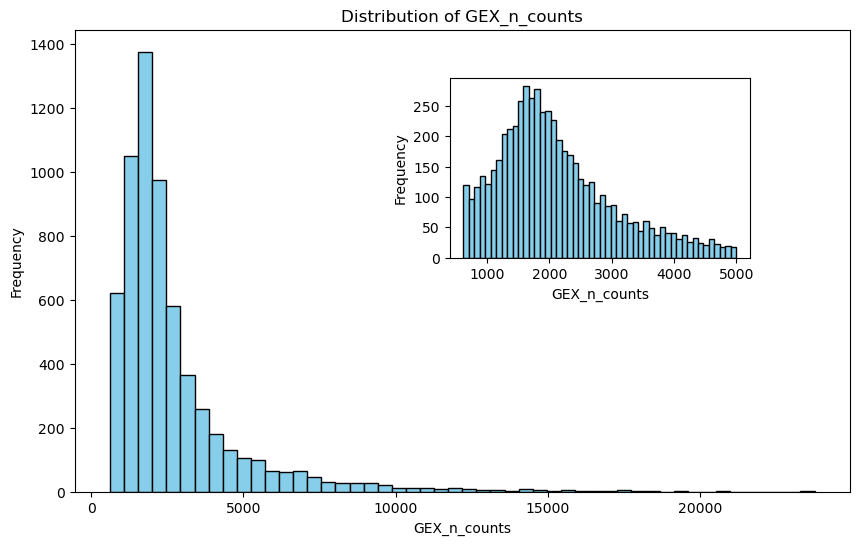

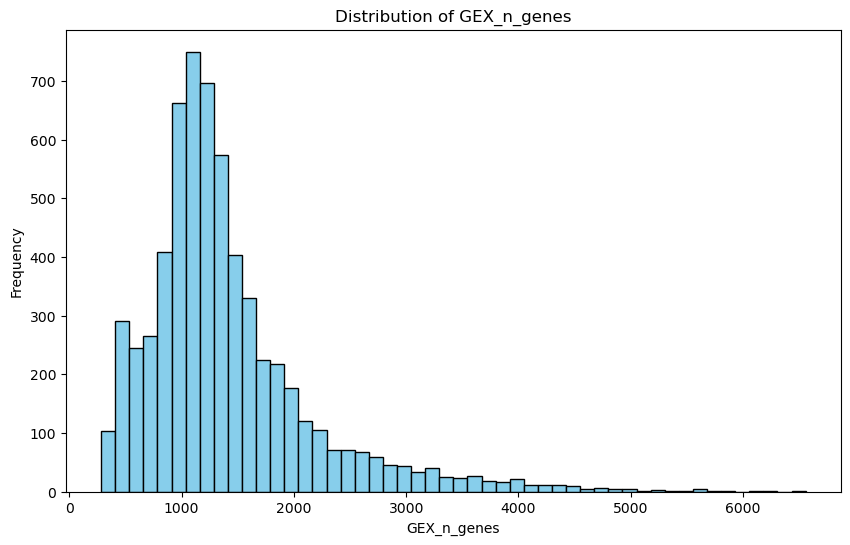

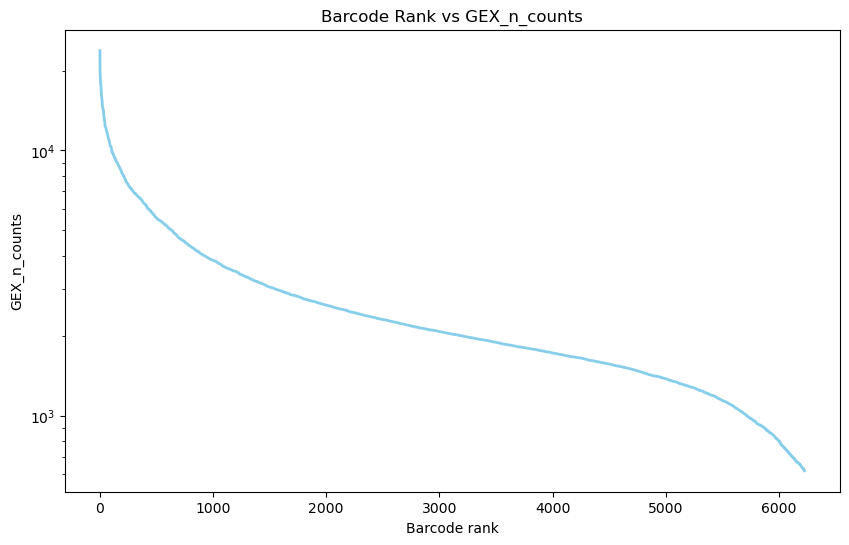

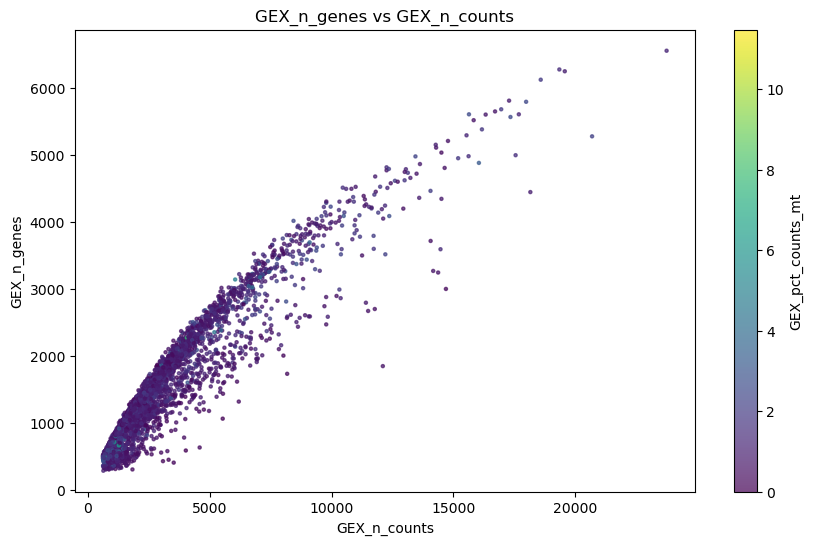

In [ ]:
data_to_plot = single_cell_data_obj.meta_data

import matplotlib.pyplot as plt

# Plot 1
plt.figure(figsize=(10, 6))
plt.hist(data_to_plot['GEX_n_counts'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('GEX_n_counts')
plt.ylabel('Frequency')
plt.title('Distribution of GEX_n_counts')

plt.axes([0.5, 0.5, 0.3, 0.3])
plt.hist(data_to_plot['GEX_n_counts'][data_to_plot['GEX_n_counts'] < 5000], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('GEX_n_counts')
plt.ylabel('Frequency')
plt.savefig('plot_1', dpi=300) 
plt.show()

# Plot 2
plt.figure(figsize=(10, 6))
plt.hist(data_to_plot['GEX_n_genes'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('GEX_n_genes')
plt.ylabel('Frequency')
plt.title('Distribution of GEX_n_genes')
plt.savefig('plot_2', dpi=300) 
plt.show()

# Plot 3
sorted_counts = np.sort(data_to_plot['GEX_n_counts'])[::-1]  
barcode_rank = np.arange(1, len(sorted_counts) + 1)  

plt.figure(figsize=(10, 6))
plt.plot(barcode_rank, sorted_counts, color='skyblue', linewidth=2)
plt.yscale('log')  
plt.xlabel('Barcode rank')
plt.ylabel('GEX_n_counts')
plt.title('Barcode Rank vs GEX_n_counts')
plt.savefig('plot_3', dpi=300) 
plt.show()

# Plot 4
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data_to_plot['GEX_n_counts'], data_to_plot['GEX_n_genes'], 
                      c=data_to_plot['GEX_pct_counts_mt'], cmap='viridis', s=5, alpha=0.7)
plt.xlabel('GEX_n_counts')
plt.ylabel('GEX_n_genes')
plt.title('GEX_n_genes vs GEX_n_counts')
cbar = plt.colorbar(scatter)
cbar.set_label('GEX_pct_counts_mt')
plt.savefig('plot_4', dpi=300) 
plt.show()